In [2]:
library(tidyverse)
library(pheatmap)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
 #installing arcadia colors for figs
remotes::install_github("Arcadia-Science/arcadiathemeR")
library(arcadiathemeR)

Skipping install of 'arcadiathemeR' from a github remote, the SHA1 (f9de946c) has not changed since last install.
  Use `force = TRUE` to force installation

Loading fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [4]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)

# Serine Protease vs Tick Inhibitor AF-Multimer Predictions
This notebook analyzes results for screening human serine proteases against tick TIL-domain serine protease inhibitors that are predicted to suppress host detection mechanisms like itch, pain, or inflammation. We first used screened the protease inhibitor `Amblyomma-americanum_evm.model.contig-94090-1.4` against nearly 500 human serine proteases, and selected those with a confidence score above 0.75. This left us with 34 serine proteases that are mostly homologous trypsin proteases such as chymotrpsins, kallikrein-like peptidases, and granzymes. In this notebook, we use pdockQ score and tissue transcriptome analysis to try and further contextualize these results. Tissues transcriptome data were retrieved for each gene in NCBI, which summarizes data from [Fagerberg et al. 2014](https://pubmed.ncbi.nlm.nih.gov/24309898/) which analyzed gene expression in 27 different tissues from 95 healthy humans. This notebook then takes these results for the preliminary run and combines with the results of screening 9 other members of the OG0000058 family against the set of 34 potential targets `Amblyomma-americanum_evm.model.contig-94090-1.4`. 


### First we are reading in our AF multimer hits, and adding tissue expression data to them

In [5]:
# read in data and merge tables 

# serine protease uniprot metadata with expression data 
# for each serine protease the main cell type or tissue that it is expressed in is recorded for plotting, specifically highlighting those expressed in immune cells and skin, all other types are listed as "other"
serine_protease_metadata <- read.csv("../datasheets/select-serine-protease-expression-metadata.csv")

# preliminary alphafold-multimer results from 94090-1.4
# filtered to the top hits for 34 serine proteases that were then screened against the other 9 protease inhibitors
preliminary_filtered_results <- read.csv("../outputs/protein_protein_interaction_results/Amblyomma-americanum-94090-1.4-serine-protease-afmultimer-top-hits.csv") %>% 
    select(-dscript_confidence_score, -reviewed, -uniprot_name, -annotation, -length)

# second run alphafold-multimer results for remaining tick protease inhibitors
run2_select_results <- read.csv("../outputs/protein_protein_interaction_results/Amblyomma-americanum-full-tick-select-serine-protease-afmultimer-comps.csv", col.names = c("amblyomma_protein", "uniprot_id", "pTM", "ipTM", "afmultimer_ranking_confidence"))

# full results
combined_results <- rbind(preliminary_filtered_results, run2_select_results)

# results with metadata
combined_results_metadata <- left_join(combined_results, serine_protease_metadata)

# final table of results
write.table(combined_results_metadata, "../outputs/protein_protein_interaction_results/2024-04-11-final-serine-protease-filtered-comps-results.tsv", sep = "\t", quote = FALSE, row.names = FALSE)


Joining with `by = join_by(uniprot_id)`


### Next, we are adding in the pdockq score
This is how we generated these score using the AF mulitmer colabfold notebook: Run the script with `python3 colabfold_analysis.py <AF2MULTIMER_RESULTS_DIRECTORY>`. This will create a new folder with the same name as your input directory with `_analysis` appended at the end. This creates three CSV files: a contacts, interfaces, and summary file. The `summary.csv` is the most useful for downstream steps and is how we calculated the pDockQ score for each interaction prediction. The contacts and interfaces files give more information for each residue the calculated metrics, whereas the summary file is an average across all residues. You can find our AF multimer results directory here: https://zenodo.org/records/15186244

In [6]:
# Read the TSV that has pDockq scores, AF ranking scores, and tissue expression 

data <- read_tsv("../outputs/protein_protein_interaction_results/2024-04-24-final-serine-protease-filtered-interface-comps-results.tsv") %>%
  distinct(uniprot_name, amblyomma_protein, .keep_all = TRUE)

Rows: 341 Columns: 19
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): amblyomma_protein, uniprot_id, uniprot_name, annotation, ncbi_huma...
dbl (11): avg_n_models, max_n_models, num_contacts_with_max_n_models, num_un...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Now we do a little annotation to the file to set us up for downstream plotting

In [7]:

#highlighting pancreas hits
data <- data %>%
  mutate(primary_expression = ifelse(grepl("pancreas", full_expression, ignore.case = TRUE), 
                                     "pancreas", 
                                     primary_expression))
#changing none expression to "other"
data <- data %>%
  mutate(primary_expression = ifelse(grepl("none", primary_expression, ignore.case = TRUE), 
                                     "other", 
                                     primary_expression))
#reformatting uniprot names
data <- data %>%
  mutate(uniprot_name = sub("_HUMAN$", "", uniprot_name))

#reformatting annotations
data <- data %>%
  mutate(Name = sub("^(.*?)\\s*\\(.*", "\\1", annotation))




### Lets compare pDockQ top hits vs AF multimer top hits for Amblyomma-americanum_evm.model.contig-94090-1.4


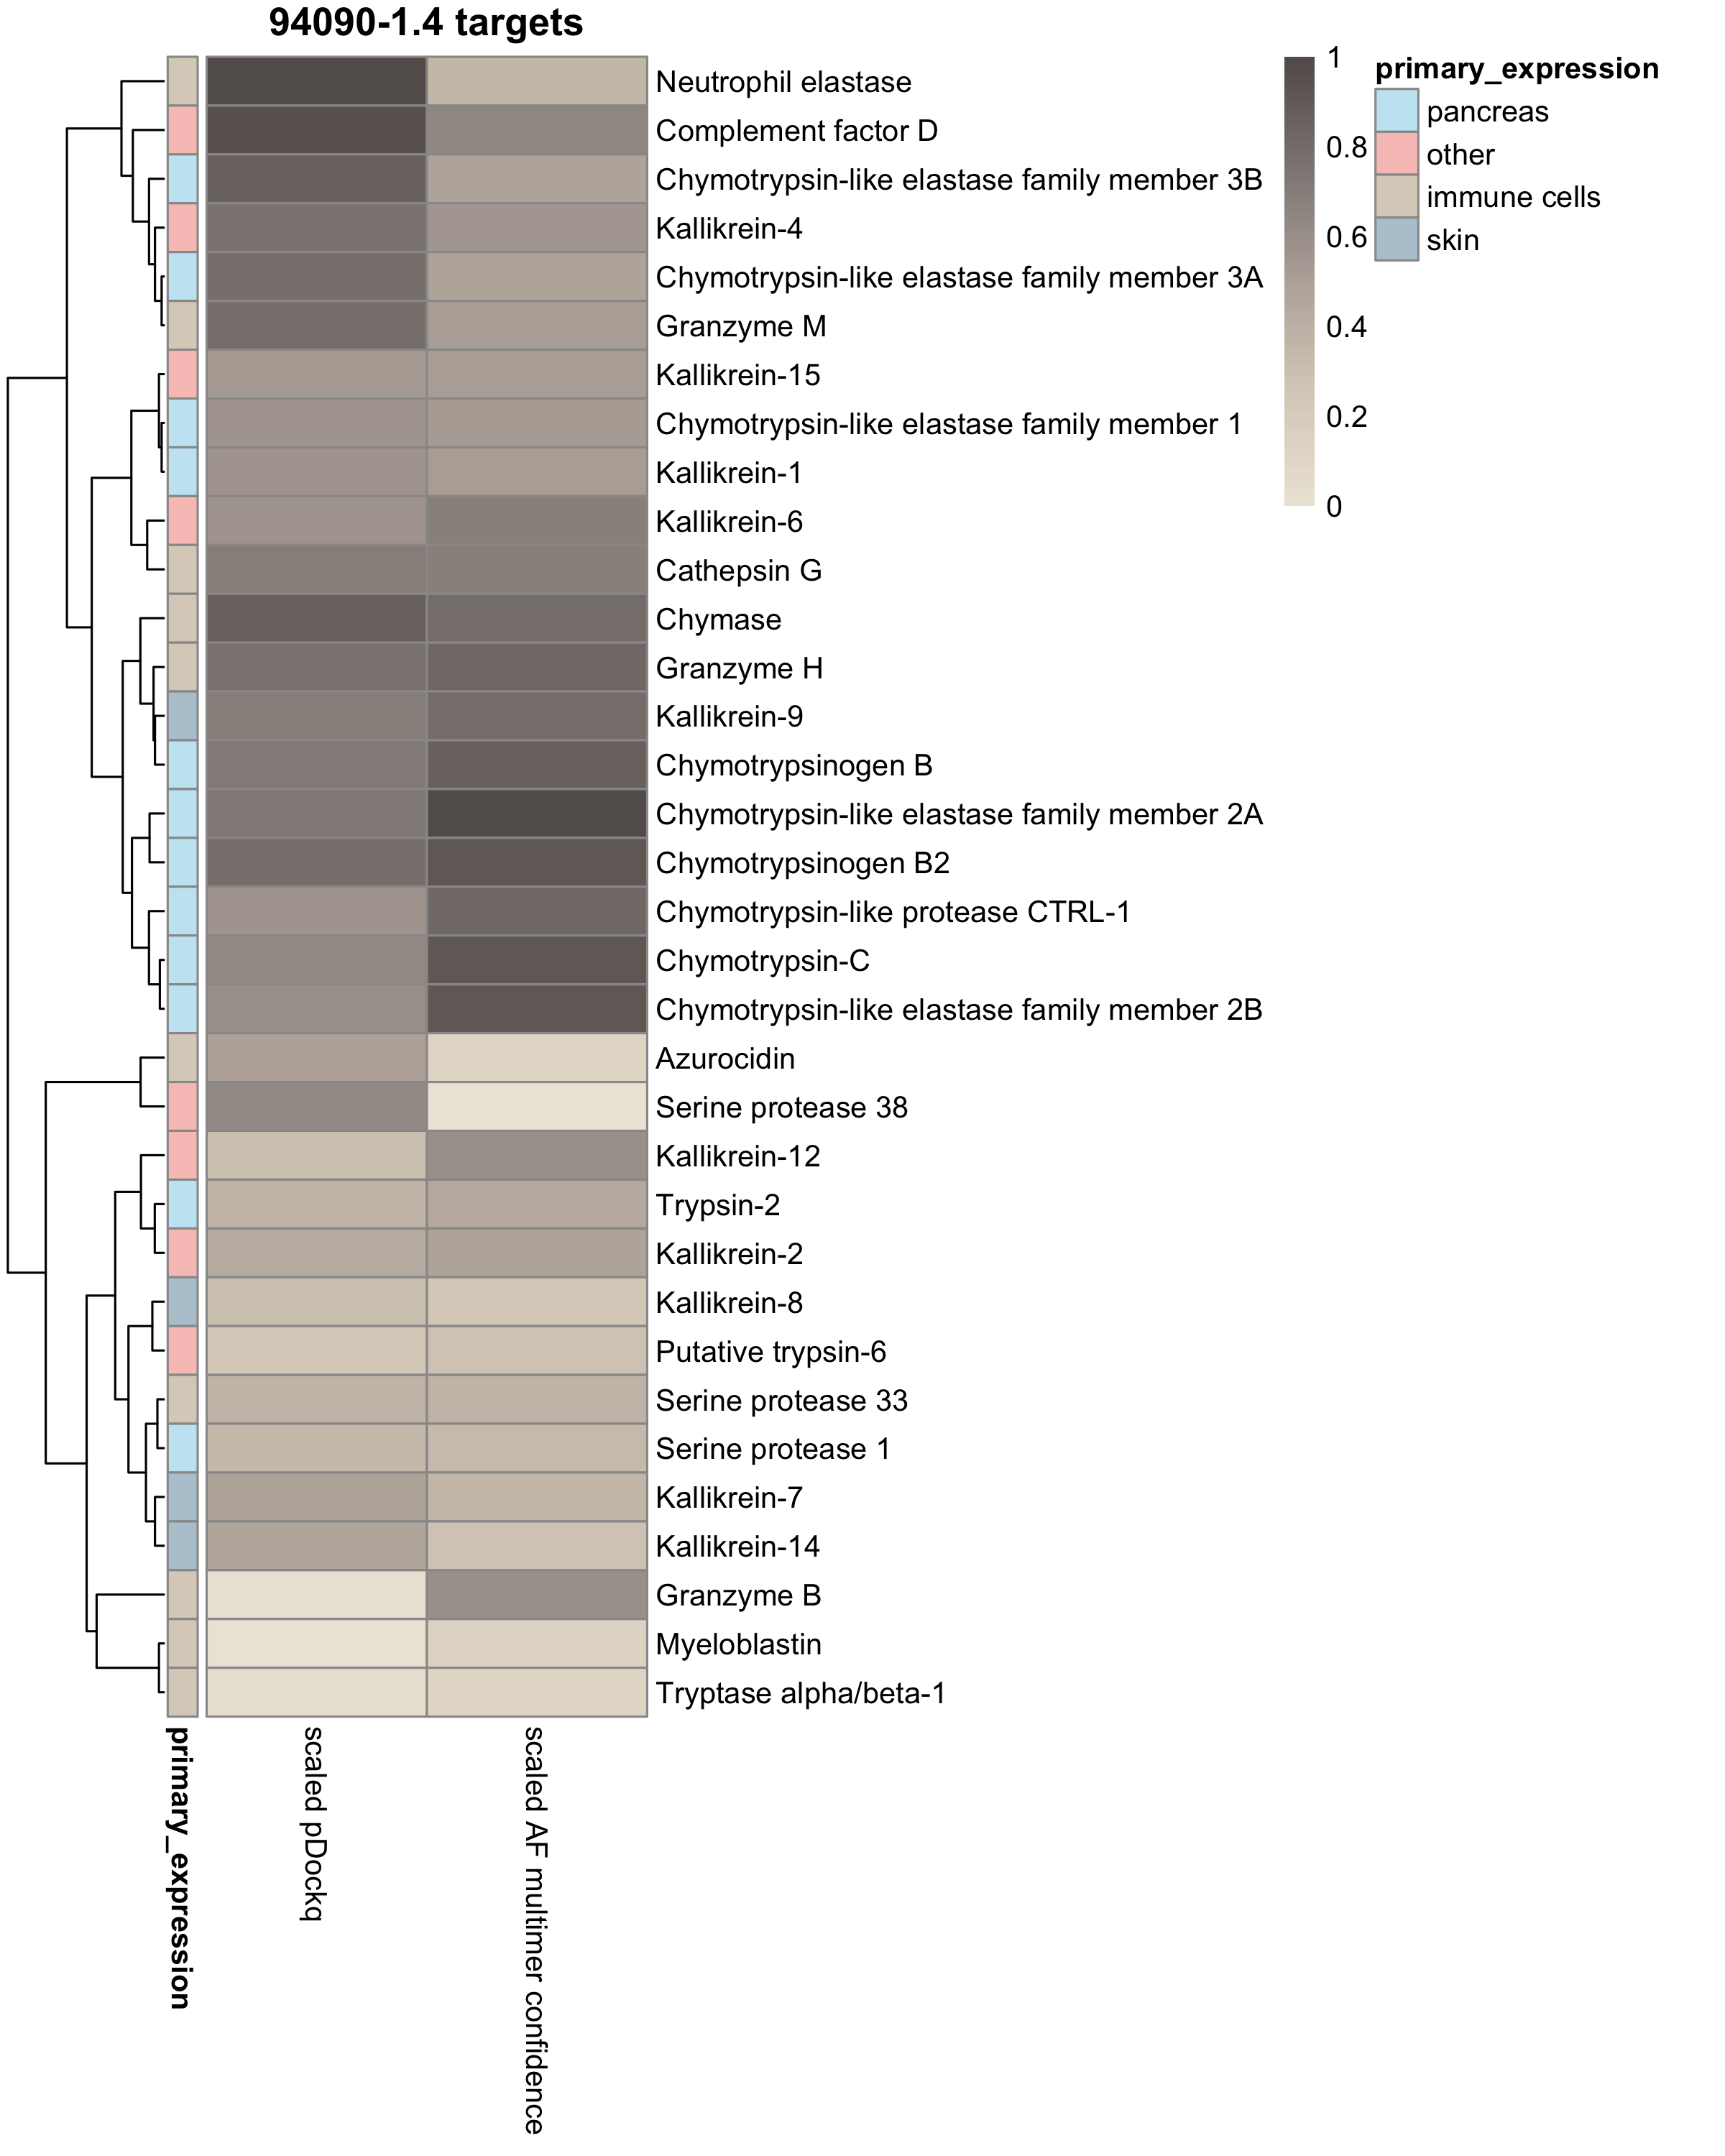

In [10]:

# subsetting out Amblyomma-americanum_evm.model.contig-94090-1.4 to work with 
subset_data <- data %>%
  filter(amblyomma_protein == "Amblyomma-americanum_evm.model.contig-94090-1.4")


# Select only the columns you want for the heatmap
heatmap_data <- subset_data %>%
  select(Name,best_pdockq, afmultimer_ranking_confidence)

# Set 'Name' as row names
# Row names are what pheatmap will use as labels
heatmap_matrix <- as.data.frame(heatmap_data)
rownames(heatmap_matrix) <- heatmap_matrix$Name
heatmap_matrix <- heatmap_matrix[, -which(names(heatmap_matrix) == "Name")]  

# Make annotation dataframe of tissue expression labels 
annotation_row <- subset_data %>%
  select(Name, primary_expression) %>%
  as.data.frame()

rownames(annotation_row) <- annotation_row$Name
annotation_row <- annotation_row[ , "primary_expression", drop = FALSE]  # keep it as a dataframe

# Get the "secondar" arcadia palette
primary_colors <- arcadia_palette("secondary")

# Get unique annotation categories
groups <- unique(annotation_row$primary_expression)

# Assign colors from the palette
ann_colors <- list(primary_expression = setNames(primary_colors[seq_along(groups)], groups))

#scaling to get pDockq and AF ranking on same scale
heatmap_matrix_scaled <- as.data.frame(lapply(heatmap_matrix, function(x) {
  (x - min(x, na.rm=TRUE)) / (max(x, na.rm=TRUE) - min(x, na.rm=TRUE))
}))

#renaming the cols to reflect scaling
colnames(heatmap_matrix_scaled) <- c("scaled pDockq", "scaled AF multimer confidence")

# preserve rownames
rownames(heatmap_matrix_scaled) <- rownames(heatmap_matrix)  


# Get the base colors from the Arcadia palette
base_colors <- arcadia_palette("warm_gray_shades")

# Interpolate to make a smooth gradient (e.g. 100 steps)
my_gradient <- colorRampPalette(base_colors)(100)

# make the plot bigger
options(repr.plot.width=8, repr.plot.height=10)  

#make heatmap! 

heatmap =  pheatmap(as.matrix(heatmap_matrix_scaled),
           scale = "none",
           annotation_row = annotation_row,   # <- THIS adds the color bar
           color = my_gradient,
           annotation_colors = ann_colors,

           fontsize_row = 10,
           fontsize_col = 10,
           cluster_rows = TRUE,    # <-- still cluster rows
           cluster_cols = FALSE,   # <-- disables column clustering
           main = "94090-1.4 targets")
ggsave("../outputs/figures/94090-1.4_pdockq_AF_ranking.png", heatmap, width=10, height=10, units=c("in"))
ggsave("../outputs/figures/94090-1.4_pdockq_AF_ranking.pdf", heatmap, width=10, height=10, units=c("in"))


### Now we add in more tick protease inhibitors

#### Plotting out AF multimer ranking confidence for all 10 OG0000058 orthologs


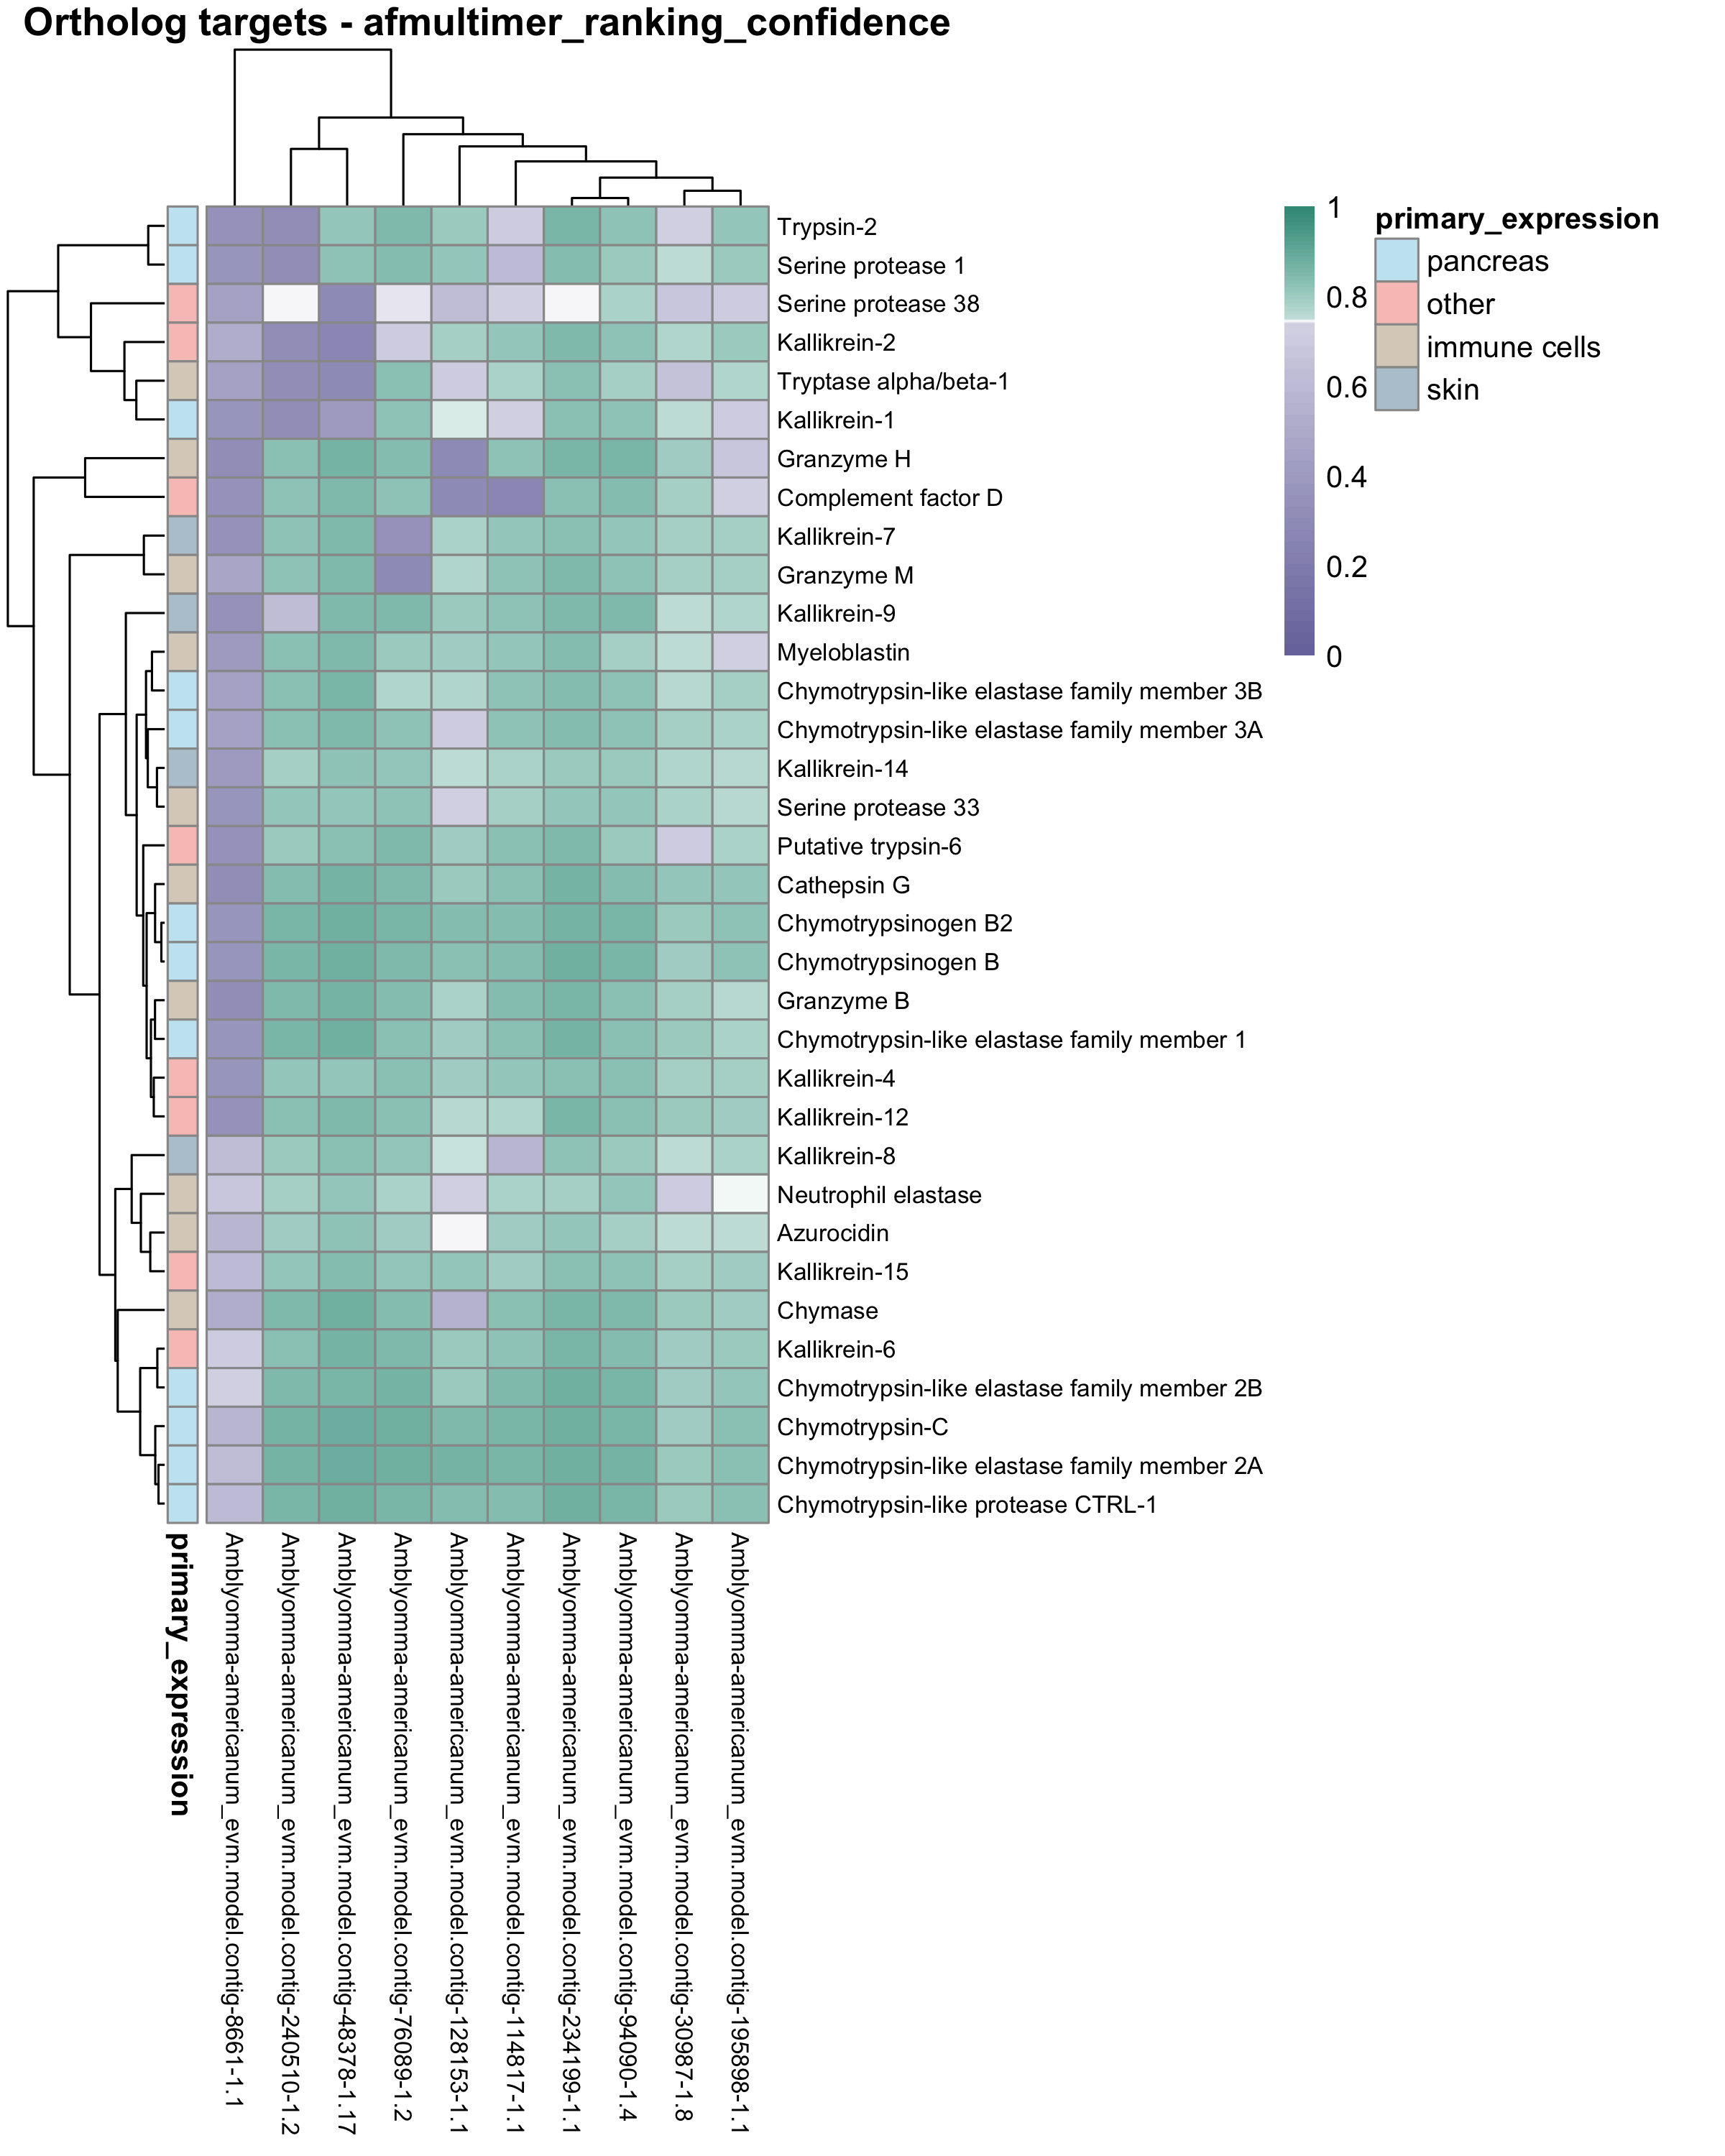

In [23]:
# Select the columns you care about
long_data <- data %>%
  select(Name, amblyomma_protein,afmultimer_ranking_confidence)

# Reshape (pivot wider) to make each gene-protein-metric combination a column
wide_data <- long_data %>%
  pivot_wider(
    names_from = amblyomma_protein,
    values_from = afmultimer_ranking_confidence 
  )

# Make 'Name' the rownames
heatmap_matrix <- as.data.frame(wide_data)
rownames(heatmap_matrix) <- heatmap_matrix$Name
heatmap_matrix <- heatmap_matrix[, -which(names(heatmap_matrix) == "Name")]

# Create compressed breaks
breaks <- c(seq(0, 0.74, length.out=30),
            seq(0.7401, .75, length.out=20),
            seq(0.7501, 1, length.out=30))

# Make Diverging palette
diverging_colors <- colorRampPalette(c("#7A77AB", "#FFFFFF", "#3B9886"))(length(breaks) - 1)



# Step 5: Plot!
heatmap = pheatmap(as.matrix(heatmap_matrix),
         color = diverging_colors,
         breaks = breaks,
         fontsize_row = 8,
         fontsize_col = 8,
         cluster_rows = TRUE,    
         cluster_cols = TRUE,   
         annotation_row = annotation_row,
         annotation_colors = ann_colors,
         main = "Ortholog targets - afmultimer_ranking_confidence")

ggsave("../outputs/figures/all_PIs_AF_score.png", heatmap, width=8, height=10, units=c("in"))
ggsave("../outputs/figures/all_PIs_AF_score.pdf", heatmap, width=8, height=10, units=c("in"))


#### Plotting out pdockq score for all 10 OG0000058 orthologs


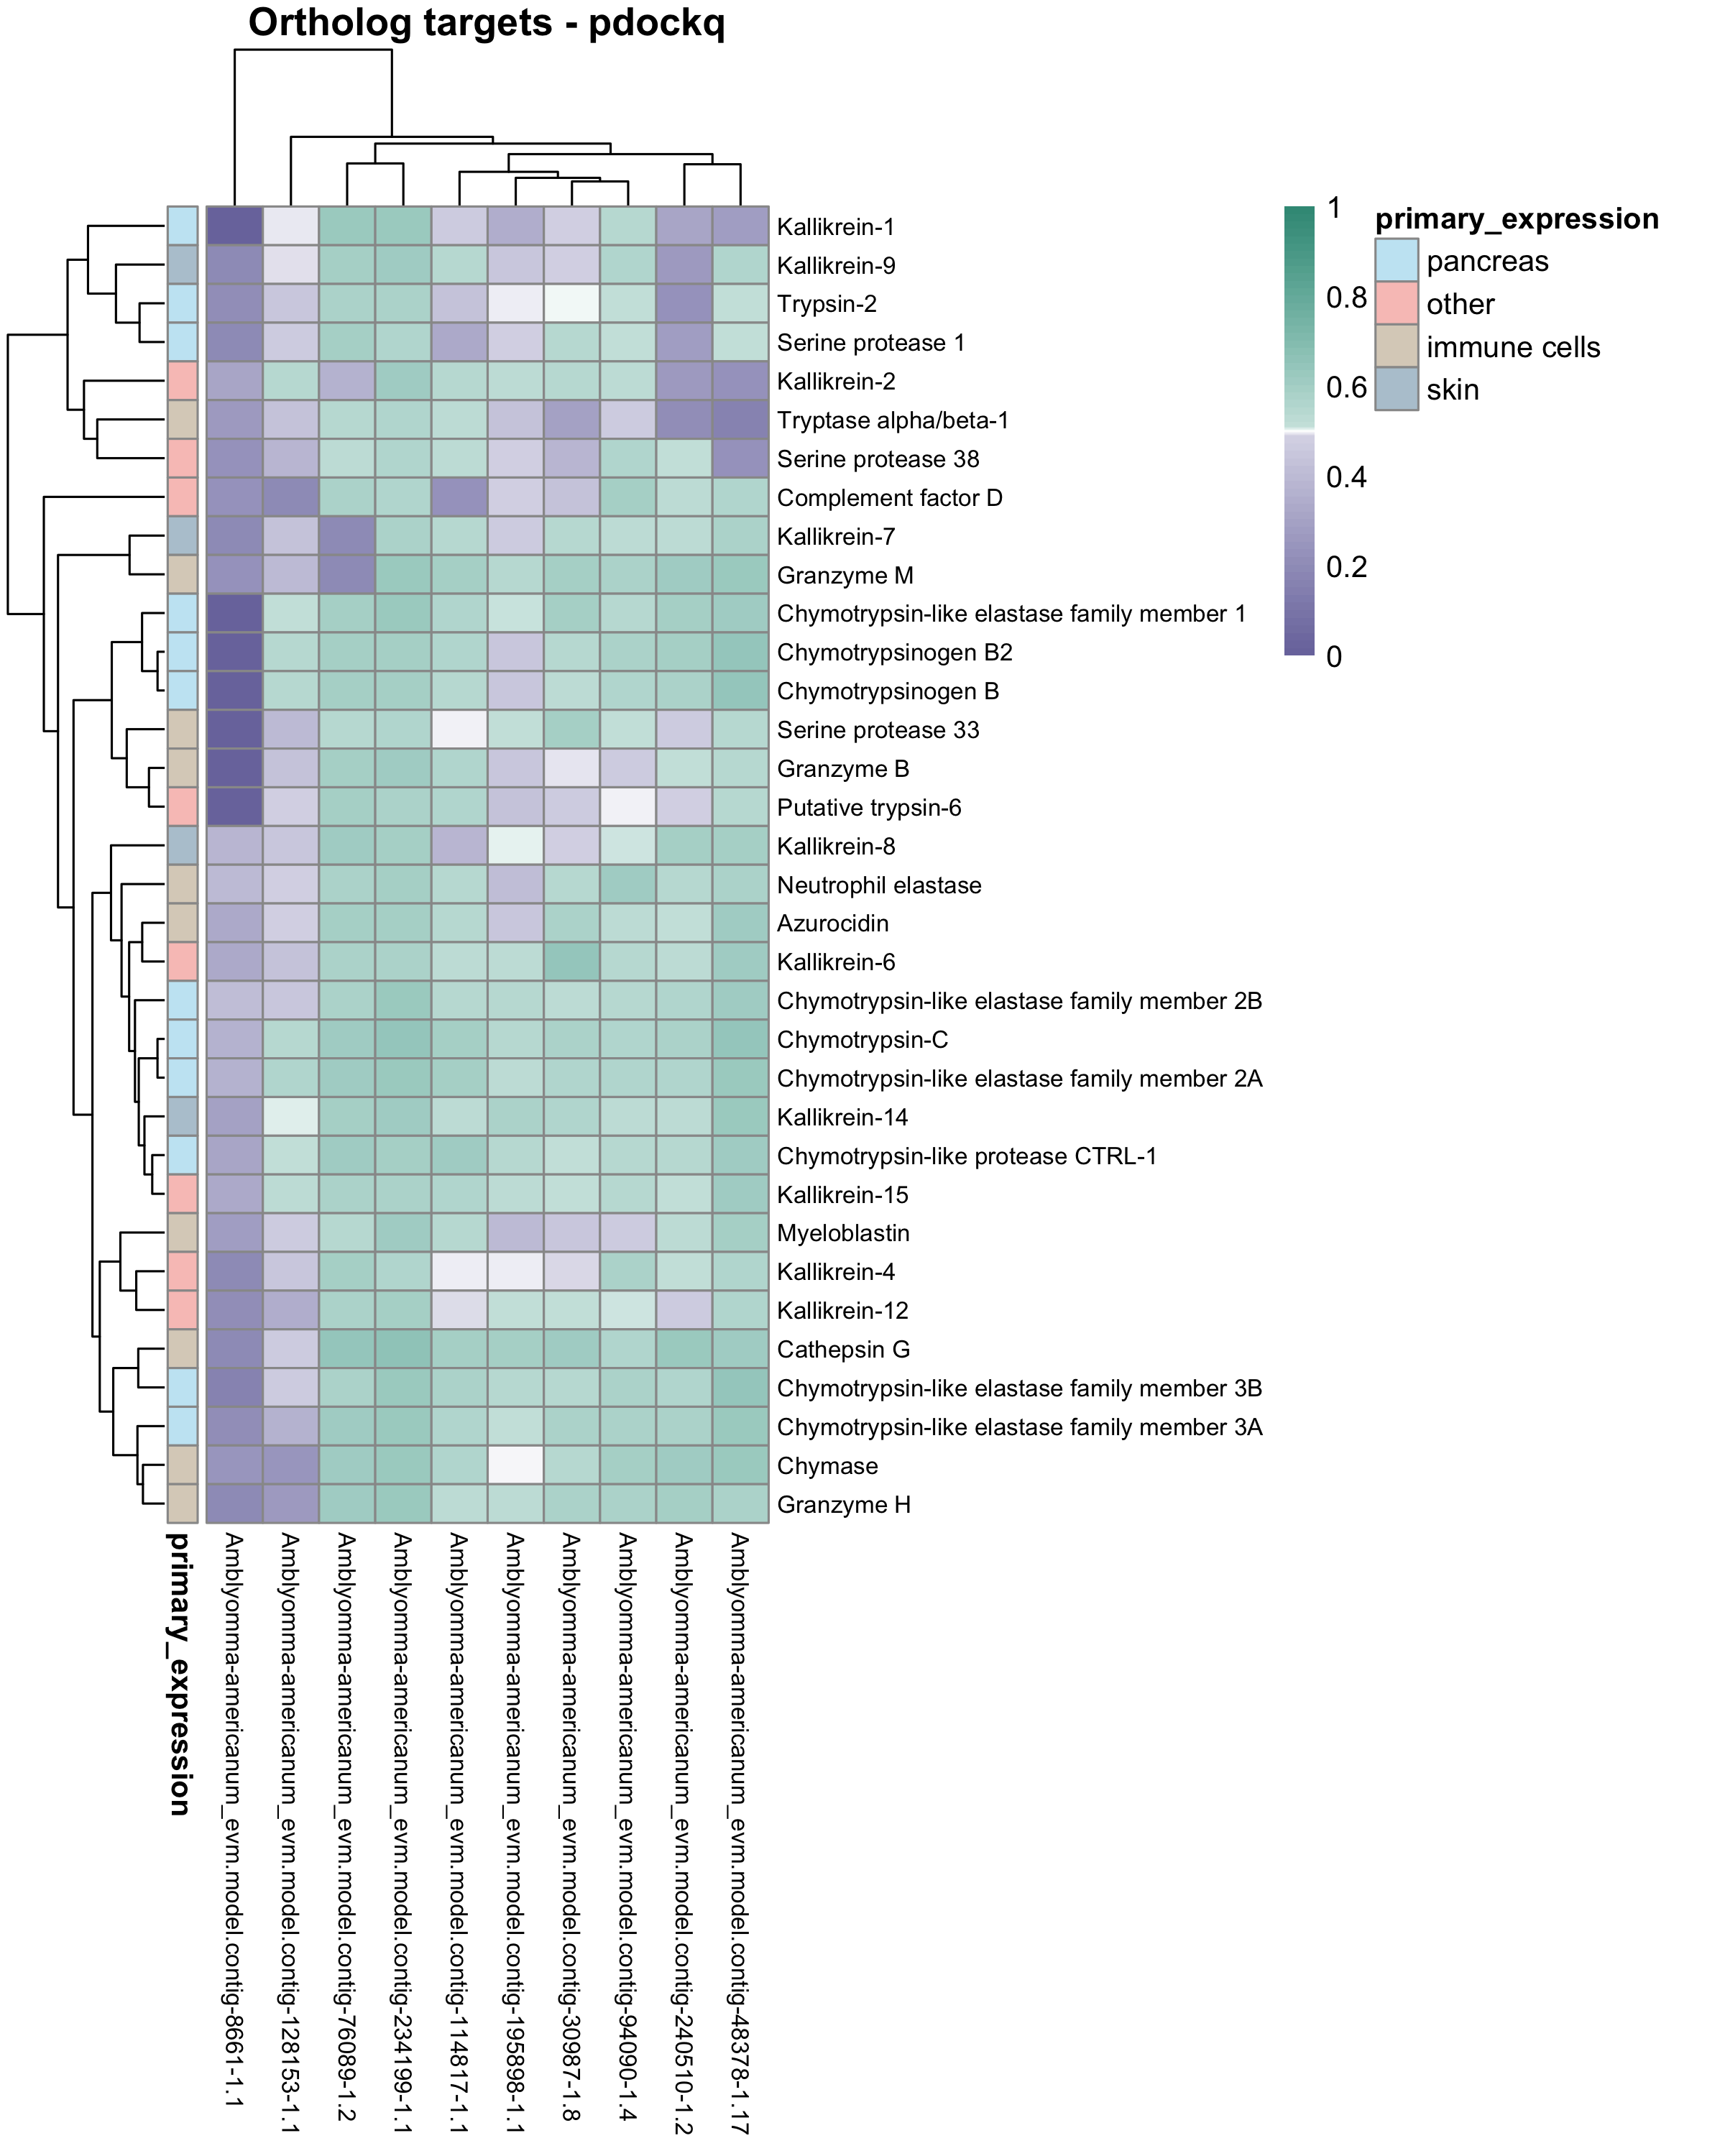

In [24]:

# Select the columns you care about
long_data <- data %>%
  select(Name, amblyomma_protein,best_pdockq)

# Reshape (pivot wider) to make each gene-protein-metric combination a column
wide_data <- long_data %>%
  pivot_wider(
    names_from = amblyomma_protein,
    values_from = best_pdockq 
  )

# Make 'Name' the rownames
heatmap_matrix <- as.data.frame(wide_data)
rownames(heatmap_matrix) <- heatmap_matrix$Name
heatmap_matrix <- heatmap_matrix[, -which(names(heatmap_matrix) == "Name")]

# Create compressed breaks
breaks <- c(seq(0, 0.49, length.out=30),
            seq(0.4901, 0.51, length.out=20),
            seq(0.52, 1, length.out=30))

# Make Diverging palette
diverging_colors <- colorRampPalette(c("#7A77AB", "#FFFFFF", "#3B9886"))(length(breaks) - 1)



# Step 5: Plot!
heatmap = pheatmap(as.matrix(heatmap_matrix),
         color = diverging_colors,
         breaks = breaks,
         fontsize_row = 8,
         fontsize_col = 8,
         cluster_rows = TRUE,    
         cluster_cols = TRUE,   
         annotation_row = annotation_row,
         annotation_colors = ann_colors,
         main = "Ortholog targets - pdockq")

ggsave("../outputs/figures/all_PIs_pdockq_score.png", heatmap, width=8, height=10, units=c("in"))
ggsave("../outputs/figures/all_PIs_pdockq_score.pdf", heatmap, width=8, height=10, units=c("in"))


# Conclusions
  We found that Amblyomma-americanum_evm.model.contig-94090-1.4 has predicted high confidence interactions with 34 human proteases. However, while we see interesting hits to immune and skin related proteases, we aren't sure about overall biological plausibility of our results as many of our predicted target proteases are digestive enzymes and are predominantly expressed in the pancreas. We tried other scoring approaches, but didn't see any discriminatory power in using pdockq score vs. AF multimer ranking confidence. Last, we analyzed the predicted interactions between nine other tick protease inhibitors from the same family, and the 34 protease that the original inhibitor was predicted to target. We found that most of the 34 serine proteases have high confident PPIs with the tick protease inhibitors, with the exception of Amblyomma-americanum_evm.model.contig-8661-1.1. We later found that this protease inhibitor has a very low quality structure, likely driving these results.

In [29]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/adairborges/miniconda3/envs/tick_ppi/lib/libopenblasp-r0.3.29.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 pheatmap_1.0.12     lubridate_1.9.4    
 [4] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
 [7] purrr_1.0.4         readr_2.1.5         tidyr_1.3.1        
[10] tibble_3.2.1        ggplot2_3.5.2       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] generics_0.1.3     stringi_1.8.7      extrafontdb_1.0    hms_1.1.3         
 [5] digest_0.6.37      magrittr_2.0.3     evaluate_1.0.3     grid_4.3.3        
 [9] timechange_0.3.0